In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nqDataLoader as nq #data loading library
from keras.preprocessing import sequence
import tensorflow as tf
tf.random.set_seed(0)
np.random.seed(0)


In [2]:
## importing the early stage dataset 
early_stage = pd.read_csv('GT_DataPD_MIT-CS2PD.csv')
# X = dataset.iloc[:, :-1].values
# y = dataset.iloc[:, -1].values
early_stage["gt"] = early_stage["gt"].astype(int)
early_stage.head()

,pID,gt,updrs108,afTap,sTap,nqScore,typingSpeed,file_1
0,1000,1,27,79.0,184.5,0.107179,56.866667,1424946827.1000_001_014.csv
1,1001,1,16,96.5,189.0,0.056286,118.000000,1427279751.1001_001_014.csv
2,1002,0,5,140.0,158.0,0.039519,119.037037,1426676689.1002_001_014.csv
3,1004,1,22,83.5,191.5,0.034853,74.266667,1429866367.1004_001_014.csv
4,1005,1,17,68.0,150.0,0.048307,74.969697,1430134526.1005_001_014.csv


In [3]:
hit_time_series = []
for index, row in early_stage.iterrows():
    fileloc = row.file_1
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( "data_MIT-CS2PD/" + early_stage.loc[index]['file_1'])
    htArr =np.array(htArr)
    hit_time_series.append(htArr)

X1 = hit_time_series 

In [4]:
## importing the de-novo dataset 
de_novo = pd.read_csv('GT_DataPD_MIT-CS1PD.csv')
# X = dataset.iloc[:, :-1].values
# y = dataset.iloc[:, -1].values
print(len(de_novo))
de_novo["gt"] = de_novo["gt"].astype(int)
de_novo.head()

31


,pID,gt,updrs108,afTap,sTap,nqScore,typingSpeed,file_1,file_2
0,11,1,14.25,NaN,162.25,0.117543,189.372549,1402930351.011_001_014.csv,1403706430.011_003_014.csv
1,60,0,2.00,NaN,162.25,0.070350,60.533333,1402932300.060_001_014.csv,1403708258.060_003_014.csv
2,67,1,25.25,NaN,133.75,0.223411,54.333333,1401117235.067_001_014.csv,1401978395.067_003_014.csv
3,68,0,6.00,NaN,159.00,0.074973,71.800000,1401114972.068_001_014.csv,1401980765.068_003_014.csv
4,70,1,26.25,NaN,113.50,0.175751,39.614035,1404311419.070_001_014.csv,1404743687.070_003_014.csv


In [5]:
##using both files 
hit_time_series = []
for index, row in de_novo.iterrows():
    fileloc1 = row.file_1
    keyPressed, htArr1, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_1'])
    htArr1 = np.array(htArr1)
    keyPressed, htArr2, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_2'])
    htArr2 = np.array(htArr2)
    htArr =np.concatenate((htArr1,htArr2),axis =0)
    htArr=np.array(htArr)
    hit_time_series.append(htArr)
X2 = hit_time_series 

In [6]:
X = np.concatenate((X1,X2),axis=0)
y=  np.concatenate((early_stage['gt'],de_novo["gt"]),axis=0)
X_filtered =[]
y_filtered =[]


for i,e in enumerate(X):
    if len(e)>1:
        X_filtered.append(e)
        y_filtered.append(y[i])
min = len(X_filtered[0])
for i,e in enumerate(X_filtered):
    if len(e)<min:
        min = len(e)
        print(i)
X_filtered = np.array(X_filtered)
y_filtered = np.array(y_filtered)
X_lens = [len(e) for e in X_filtered]
avg_len = np.mean(X_lens)
print(avg_len)
print(min)
print(len(X_filtered),len(y_filtered))
print(X_filtered)
print(y_filtered)

15
40
43
1975.5882352941176
299
85 85
[array([0.3179, 0.1892, 0.1641, 0.2597, 0.1994, 0.1016, 0.122 , 0.139 ,
        0.147 , 0.2011, 0.0758, 0.1902, 0.1341, 0.1766, 0.0912, 0.2218,
        0.1295, 0.1171, 0.1057, 0.077 , 0.0969, 0.2141, 0.1101, 0.1355,
        0.1697, 0.1038, 0.1234, 0.1405, 0.1393, 0.1209, 0.1359, 0.1342,
        0.1935, 0.0775, 0.1834, 0.178 , 0.2392, 0.1381, 0.1584, 0.1741,
        0.1349, 0.2007, 0.1402, 0.1964, 0.2102, 0.1575, 0.1527, 0.0831,
        0.1709, 0.1588, 0.1162, 0.1702, 0.1259, 0.1004, 0.1751, 0.1479,
        0.1835, 0.1342, 0.1687, 0.1576, 0.1129, 0.2006, 0.1176, 0.1315,
        0.2539, 0.1244, 0.1316, 0.1911, 0.1904, 0.1438, 0.1757, 0.1734,
        0.1517, 0.18  , 0.1208, 0.1003, 0.1092, 0.1556, 0.1204, 0.2012,
        0.1609, 0.214 , 0.1929, 0.3871, 0.1575, 0.118 , 0.1306, 0.2313,
        0.1446, 0.1225, 0.1309, 0.1261, 0.1912, 0.1307, 0.1356, 0.0955,
        0.1739, 0.1349, 0.1399, 0.1971, 0.1133, 0.1099, 0.1257, 0.1404,
        0.153 , 0.1179, 0.

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\micoa\AppData\Local\Temp\ipykernel_11016\4195563876.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_filtered = np.array(X_filtered)


In [7]:
import itertools
flat_list = list(itertools.chain(*X_filtered))
value = sum(flat_list) / len(flat_list)
print(value)
X_filtered =sequence.pad_sequences(X_filtered,dtype='float32',padding='post',maxlen=6000,value =1)



0.11633377817478088


In [8]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_filtered,y_filtered,test_size=0.17,random_state=0)

In [10]:
X_train.shape


(70, 6000)

In [11]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X_train = sc.fit_transform(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], int(X_train.shape[1]),1))
print(X_train)
X_test = sc.transform(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], int(X_test.shape[1]),1))

[[[0.46910757]
  [0.12045828]
  [0.21827409]
  ...
  [1.        ]
  [1.        ]
  [1.        ]]

 [[0.06598015]
  [0.04680851]
  [0.03299493]
  ...
  [1.        ]
  [1.        ]
  [1.        ]]

 [[0.44088477]
  [0.2752864 ]
  [0.05301748]
  ...
  [1.        ]
  [1.        ]
  [1.        ]]

 ...

 [[0.46109837]
  [0.35090014]
  [0.31754088]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.16895501]
  [0.08674306]
  [0.1469261 ]
  ...
  [1.        ]
  [1.        ]
  [1.        ]]

 [[0.01678108]
  [0.07463175]
  [0.10434292]
  ...
  [1.        ]
  [1.        ]
  [1.        ]]]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6000, 100)         40800     
_________________________________________________________________
dropout (Dropout)            (None, 6000, 100)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 6000, 100)         80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 6000, 100)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 6000, 100)         80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 6000, 100)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               8

1/1 [==============================] - 3s 3s/step - loss: 0.6879 - accuracy: 0.4143
Epoch 70/200
1/1 [==============================] - 2s 2s/step - loss: 0.6824 - accuracy: 0.5429
Epoch 71/200
1/1 [==============================] - 3s 3s/step - loss: 0.6883 - accuracy: 0.4857
Epoch 72/200
1/1 [==============================] - 2s 2s/step - loss: 0.6839 - accuracy: 0.5143
Epoch 73/200
1/1 [==============================] - 2s 2s/step - loss: 0.6825 - accuracy: 0.4714
Epoch 74/200
1/1 [==============================] - 2s 2s/step - loss: 0.6793 - accuracy: 0.5571
Epoch 75/200
1/1 [==============================] - 3s 3s/step - loss: 0.6822 - accuracy: 0.5714
Epoch 76/200
1/1 [==============================] - 2s 2s/step - loss: 0.6797 - accuracy: 0.5714
Epoch 77/200
1/1 [==============================] - 2s 2s/step - loss: 0.6870 - accuracy: 0.5000
Epoch 78/200
1/1 [==============================] - 2s 2s/step - loss: 0.6834 - accuracy: 0.5286
Epoch 79/200
1/1 [=========================

1/1 [==============================] - 3s 3s/step - loss: 0.6838 - accuracy: 0.5143
Epoch 154/200
1/1 [==============================] - 3s 3s/step - loss: 0.6817 - accuracy: 0.5714
Epoch 155/200
1/1 [==============================] - 3s 3s/step - loss: 0.6808 - accuracy: 0.5857
Epoch 156/200
1/1 [==============================] - 3s 3s/step - loss: 0.6803 - accuracy: 0.5857
Epoch 157/200
1/1 [==============================] - 3s 3s/step - loss: 0.6824 - accuracy: 0.5857
Epoch 158/200
1/1 [==============================] - 3s 3s/step - loss: 0.6837 - accuracy: 0.4714
Epoch 159/200
1/1 [==============================] - 3s 3s/step - loss: 0.6861 - accuracy: 0.4857
Epoch 160/200
1/1 [==============================] - 3s 3s/step - loss: 0.6826 - accuracy: 0.5000
Epoch 161/200
1/1 [==============================] - 3s 3s/step - loss: 0.6811 - accuracy: 0.5571
Epoch 162/200
1/1 [==============================] - 3s 3s/step - loss: 0.6828 - accuracy: 0.5000
Epoch 163/200
1/1 [===============

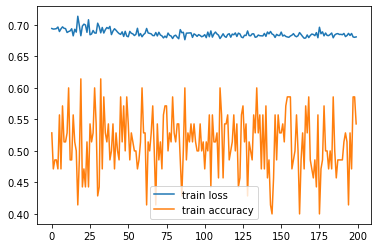

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from matplotlib import pyplot
from keras import optimizers


clf = Sequential()
clf.add(LSTM(units = 100,return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
clf.add(Dropout(0.2))
clf.add(LSTM(units = 100,return_sequences = True))
clf.add(Dropout(0.2))
clf.add(LSTM(units = 100,return_sequences = True))
clf.add(Dropout(0.2))
clf.add(LSTM(units =100 ))
clf.add(Dropout(0.2))
clf.add(Dense(units = 1,activation='sigmoid'))
es = EarlyStopping(monitor='loss', mode='auto', patience =50 ,verbose=1,restore_best_weights=True)
adm = tf.keras.optimizers.Adam()
clf.compile(loss='binary_crossentropy', optimizer=adm, metrics=['accuracy'])
print(clf.summary())



history=clf.fit(X_train, y_train, epochs=200, batch_size=70)
scores = clf.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
train_acc = clf.evaluate(X_train, y_train, verbose=0)
test_acc = clf.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc[1], test_acc[1]))
# plot training history
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['accuracy'], label='train accuracy')
# pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier
def LSTM_Network(neurons=30,dropout=0.2):

    clf = Sequential()
    clf.add(LSTM(units = neurons ,return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    clf.add(Dropout(dropout))
    clf.add(LSTM(units = neurons ,return_sequences = True))
    clf.add(Dropout(dropout))
    clf.add(LSTM(units = neurons ,return_sequences = True))
    clf.add(Dropout(dropout))
    clf.add(LSTM(units =neurons))
    clf.add(Dropout(dropout))
    clf.add(Dense(units = 100,activation='relu'))
    clf.add(Dense(units = 1,activation='sigmoid'))
    es = EarlyStopping(monitor='loss', mode='auto', patience =50 ,verbose=1,restore_best_weights=True)
    adm = tf.keras.optimizers.Adam(learning_rate=0.0001)
    clf.compile(loss='binary_crossentropy', optimizer=adm, metrics=['accuracy'])
    
    print(clf.summary())
    return clf
lstm_clf = KerasClassifier(build_fn=LSTM_Network, epochs=300, batch_size=70, verbose=0)
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [14]:
# scores1=evaluate_model(lstm_clf,X_filtered,y_filtered)
# results = [scores1]

In [15]:
# pyplot.boxplot(results, labels=['RNN'], showmeans=True)
# pyplot.show()

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import numpy as np
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
cvscores = []
for train, test in kfold.split(X_filtered, y_filtered):
  # create model
    X_traincv =X_filtered[train]
    y_traincv  = y_filtered[train]
    X_testcv = X_filtered[test]
    y_testcv = y_filtered[test]
    X_traincv = np.log10(X_traincv)
    X_traincv = sc.fit_transform(X_traincv)
    X_traincv = np.reshape(X_traincv, (X_traincv.shape[0], int(X_traincv.shape[1]),1))
    X_testcv = np.log10(X_testcv)
    X_testcv = sc.transform(X_testcv)
    X_testcv = np.reshape(X_testcv, (X_testcv.shape[0], int(X_testcv.shape[1]),1))
    clf = Sequential()
#     clf.add(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
#     clf.add(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
#     clf.add(Dropout(0.25))
#     clf.add(MaxPooling1D(pool_size=2))
    clf.add(LSTM(units=50,input_shape=(X_traincv.shape[1],1)))
    clf.add(LSTM(units = 30,return_sequences = True))
    clf.add(Dropout(0.2))
    clf.add(LSTM(units = 50,return_sequences = True))
    clf.add(Dropout(0.2))
    clf.add(LSTM(units = 50,return_sequences = True))
    clf.add(Dropout(0.2))
    clf.add(LSTM(units =50))
    clf.add(Dropout(0.2))
    clf.add(Dense(units = 100,activation='relu'))
    clf.add(Dense(units = 1,activation='sigmoid'))
    es = EarlyStopping(monitor='loss', mode='auto', patience =50 ,verbose=1,restore_best_weights=True)
    adm = tf.keras.optimizers.Adam(learning_rate=0.0001)
    ada = tf.keras.optimizers.Adadelta(
    learning_rate=0.00001, rho=0.95, epsilon=1e-07)
    bce = tf.keras.losses.BinaryCrossentropy(reduction='sum_over_batch_size')
    clf.compile(loss=bce, optimizer=adm, metrics=['accuracy']) 
    clf.fit(X_traincv, y_traincv, epochs=300, batch_size=10)
    # evaluate the model
    scores = clf.evaluate(X_testcv, y_testcv, verbose=0)
    print("%s: %.2f%%" % (clf.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
pyplot.boxplot([cvscores], labels=['RNN'], showmeans=True)
pyplot.show()

ValueError: Input 0 of layer lstm_5 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 50)